In [1]:
import pandas as pd
patch = pd.read_csv("patch.csv")
patch.head()

,val_rmse_mean,val_rmse_std,val_mae_mean,val_r2_mean,train_rmse_mean,train_mae_mean,train_r2_mean,n_folds,n_samples,model,scheme,level,atom_index,note
0,0.188953,0.053726,0.168094,-3.838650,0.1892,0.167383,-3.558292,5,510,FlaxMLP,ADCH,hf,0,NaN
1,0.035877,0.005584,0.013107,0.841620,NaN,NaN,NaN,5,510,KNN,ADCH,hf,0,NaN
2,0.065052,0.003709,0.056129,0.481692,NaN,NaN,NaN,5,510,SVR,ADCH,hf,0,NaN
3,0.008250,0.004082,0.004830,0.989646,NaN,NaN,NaN,5,510,DecisionTree,ADCH,hf,0,NaN
4,0.005610,0.002466,0.002709,0.995190,NaN,NaN,NaN,5,510,RandomForest,ADCH,hf,0,NaN


In [2]:
charges_long = pd.read_csv("df_charges_long.csv")
charges_long.describe()

,r1,r2,ang,atom_index,value
count,27540.000000,27540.000000,27540.000000,27540.000000,2.754000e+04
mean,1.004999,1.209341,149.721362,1.000000,4.990231e-07
std,0.017743,0.156952,18.231613,0.816511,5.824804e-01
min,1.000000,1.000000,120.000000,0.000000,-7.344776e-01
25%,1.000000,1.079000,132.632000,0.000000,-4.460528e-01
50%,1.000000,1.184000,148.421000,1.000000,-2.338960e-01
75%,1.000000,1.342000,164.211000,2.000000,4.961587e-01
max,1.500000,1.500000,180.000000,2.000000,1.468958e+00


In [3]:
scheme = list(charges_long["scheme"].unique())
scheme

['Hirshfeld',
 'VDD',
 'Becke',
 'ADCH',
 'CHELPG',
 'MK',
 'CM5',
 'MBIS',
 'MBIS_raw']

In [4]:
split_dfs = {}


for x,y in charges_long.groupby(["atom_index","scheme", "level"]):
    
    split_dfs[x] = y
    split_dfs[x]["r1r2"]  = (( split_dfs[x]["r1"] * split_dfs[x]["r2"] )**2 + split_dfs[x]["r1"] )/2
    split_dfs[x]["r1r2_"]  = (split_dfs[x]["r1"] + split_dfs[x]["r2"])/2



In [5]:
import matplotlib.pyplot as plt

In [6]:
P_ = list(split_dfs.keys())

In [7]:
P_

[(np.int64(0), 'ADCH', 'hf'),
 (np.int64(0), 'ADCH', 'mp2'),
 (np.int64(0), 'Becke', 'hf'),
 (np.int64(0), 'Becke', 'mp2'),
 (np.int64(0), 'CHELPG', 'hf'),
 (np.int64(0), 'CHELPG', 'mp2'),
 (np.int64(0), 'CM5', 'hf'),
 (np.int64(0), 'CM5', 'mp2'),
 (np.int64(0), 'Hirshfeld', 'hf'),
 (np.int64(0), 'Hirshfeld', 'mp2'),
 (np.int64(0), 'MBIS', 'hf'),
 (np.int64(0), 'MBIS', 'mp2'),
 (np.int64(0), 'MBIS_raw', 'hf'),
 (np.int64(0), 'MBIS_raw', 'mp2'),
 (np.int64(0), 'MK', 'hf'),
 (np.int64(0), 'MK', 'mp2'),
 (np.int64(0), 'VDD', 'hf'),
 (np.int64(0), 'VDD', 'mp2'),
 (np.int64(1), 'ADCH', 'hf'),
 (np.int64(1), 'ADCH', 'mp2'),
 (np.int64(1), 'Becke', 'hf'),
 (np.int64(1), 'Becke', 'mp2'),
 (np.int64(1), 'CHELPG', 'hf'),
 (np.int64(1), 'CHELPG', 'mp2'),
 (np.int64(1), 'CM5', 'hf'),
 (np.int64(1), 'CM5', 'mp2'),
 (np.int64(1), 'Hirshfeld', 'hf'),
 (np.int64(1), 'Hirshfeld', 'mp2'),
 (np.int64(1), 'MBIS', 'hf'),
 (np.int64(1), 'MBIS', 'mp2'),
 (np.int64(1), 'MBIS_raw', 'hf'),
 (np.int64(1), 'MBIS_

In [8]:
import numpy as np

In [44]:
scheme

['Hirshfeld',
 'VDD',
 'Becke',
 'ADCH',
 'CHELPG',
 'MK',
 'CM5',
 'MBIS',
 'MBIS_raw']

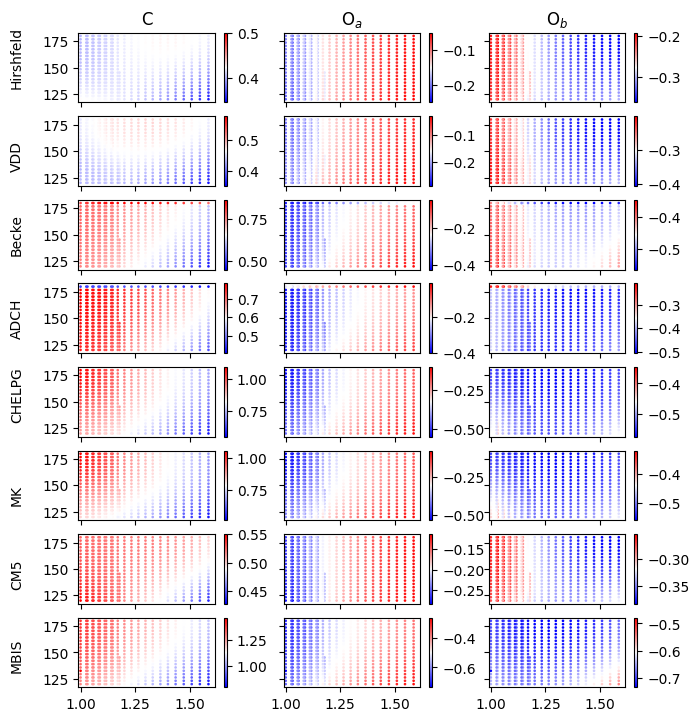

In [52]:
fig, axes = plt.subplots(8,3,figsize=(7.5,8.5), sharex=True, sharey=True)
titles = ["C", "O$_a$", "O$_b$"]
for i in range(3):
    for j, s in enumerate(scheme[:8]):
        ax = axes[j,i]
        _ = (np.int64(i), s, "mp2")
        sc = ax.scatter(split_dfs[_]["r1r2"], split_dfs[_]["ang"], c = split_dfs[_]["value"], 
                    cmap="bwr", s=0.8, vmin=split_dfs[_]["value"].min(), vmax=split_dfs[_]["value"].max() )
        plt.colorbar(sc, ax=ax)

        if i == 0:
            ax.text(-0.5, 0.25, s, transform=ax.transAxes, rotation=90)

        
        if j == 0:
            ax.set_title(titles[i])
        ax.set_xlim(0.99,1.617)




In [19]:
charges_long.groupby(["scheme", ]).describe()["value"]

,count,mean,std,min,25%,50%,75%,max
scheme,,,,,,,,
ADCH,3060.0,-8.823541e-13,0.496034,-0.504493,-0.408955,-0.243451,0.630342,0.783232
Becke,3060.0,-3.594765e-13,0.508179,-0.566010,-0.416316,-0.264895,0.652800,0.866921
CHELPG,3060.0,-3.267982e-13,0.630981,-0.575979,-0.517867,-0.354911,0.791134,1.092346
CM5,3060.0,-3.267954e-14,0.368915,-0.383262,-0.284738,-0.192725,0.506306,0.550493
Hirshfeld,3060.0,-9.150327e-13,0.300153,-0.363132,-0.231989,-0.129775,0.407424,0.500805
MBIS,3060.0,1.233581e-18,0.854387,-0.734478,-0.671170,-0.526293,1.101061,1.468953
MBIS_raw,3060.0,4.491212e-06,0.854386,-0.734467,-0.671173,-0.526284,1.101069,1.468958
MK,3060.0,-3.921578e-13,0.597194,-0.561811,-0.496355,-0.322669,0.741604,1.060563
VDD,3060.0,-1.568628e-12,0.330490,-0.405693,-0.262468,-0.134326,0.438735,0.574003


In [20]:
(patch[patch["scheme"]=="MBIS_raw"]
).groupby(["scheme", "model", ]).describe()["val_rmse_mean"].sort_values("mean")

count      mean       std       min       25%  \
scheme   model                                                             
MBIS_raw GradientBoosting    6.0  0.006306  0.001930  0.003869  0.004774   
         RandomForest        6.0  0.007239  0.002307  0.004397  0.005511   
         KNN                 6.0  0.009039  0.003611  0.004628  0.007440   
         DecisionTree        6.0  0.011563  0.005121  0.007293  0.007743   
         SVR                 6.0  0.056105  0.005724  0.049100  0.052007   
         FlaxMLP             6.0  0.211497  0.072655  0.125282  0.152770   

                                50%       75%       max  
scheme   model                                           
MBIS_raw GradientBoosting  0.006524  0.007603  0.008767  
         RandomForest      0.007151  0.009048  0.010089  
         KNN               0.008598  0.009587  0.015438  
         DecisionTree      0.009299  0.015965  0.018079  
         SVR               0.056001  0.059159  0.064641  
         FlaxMLP           0.224065  0.243462  0.316639